# [Toxic Comment Classification Challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview)

1. Анализ целевой переменной (максимум 1 балл)
- [0.5] Распределение количества классов +
- [0.5] Визуализация статистик:
  - Изолированный анализ +
  - Анализ во временном контексте - нет временного контекста

2. Анализ признаков (максимум 4 балла)
- [0.5] Типизация признаков (числовые, категориальные, временные) и их распределения +
- [0.5] Выявление аномальных значений +
- [0.5] Анализ зависимостей между признаками +
- [0.5] Анализ пропущенных значений +
- [0.5] Определение важности признаков (корреляции с таргетом) +
- [1.0] Графическая визуализация минимум 3-х пунктов выше +
- [0.5] Анализ возможных преобразований и генерации новых признаков +

3. Моделирование (максимум 3.5 балла)
- [0.25] Обоснование стратегии разделения данных (train-test split) +
Особое внимание уделить предотвращению утечки данных +
- [0.25] LAMA бейзлайн:
  - Минимум 2 различные конфигурации +
  - Выбор лучшего решения +
- [3.0] Собственное решение (если не удалось побить LLama baseline: 3 x 1.0 балл за различные пайплайны/попытки):
  - Выбор модели +
  - Построение пайплайна (препроцессинг, обработка пропусков, генерация признаков, отбор признаков, финальная модель/ансамбль) +
  - Оптимизация гиперпараметров +

4. Общие требования к коду (максимум 1.5 балла)
- [0.5] Чистый код: +-
  - Оформление ноутбука
  - Соответствие PEP 8
  - Правильное именование переменных и функций
  - Документирование функций
- [0.5] Качество кода: 
  - Следование принципам SOLID
  - Отсутствие спагетти-кода
  - Обработка предупреждений и ошибок
  - Логгирование
- [0.5] Структура решения: +
  - Оформление в виде self-contained pipeline 
  - Использование стандартных инструментов (например, sklearn pipeline)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from xgboost import XGBRegressor
import optuna
import math
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
np.random.seed(42)

import re
import warnings
warnings.filterwarnings('ignore')

C:\pyenv\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'nlp' extra dependency package 'fasttext-numpy2' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


C:\pyenv\venv\Lib\site-packages\lightautoml\transformers\text.py:23: UserWarning: 'fasttext' - package isn't installed
  warnings.warn("'fasttext' - package isn't installed")


# EDA

В соревновании представлено 4 датафрейма - трейн, тест, названия категорий для теста и файл с форматом сдачи результатов.

In [3]:
train_df = pd.read_csv(r'C:\pyenv\venv\data\train.csv')
test_df = pd.read_csv(r'C:\pyenv\venv\data\test.csv')
lables_df = pd.read_csv(r'C:\pyenv\venv\data\test_labels.csv')
sample_df = pd.read_csv(r'C:\pyenv\venv\data\sample_submission.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
print("Размер train_df:", train_df.shape)
display(train_df.head())

Размер train_df: (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Анализ целевой переменной

Целевые переменные - бинарные, 6 классов токсичности. ID будем использовать как категориальный признак, потому что задача сводится к тому, чтобы понять какие пользователи оставляют токсичные комментарии

In [39]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("Распределение классов:")
class_stats = []
for col in target_cols:
    count = train_df[col].sum()
    percentage = 100 * count / len(train_df)
    class_stats.append([col, count, percentage])
    print(f"{col}: {count} ({percentage:.2f}%)")

class_stats_df = pd.DataFrame(class_stats, columns=['Класс', 'Количество', 'Процент'])

Распределение классов:
toxic: 15294 (9.58%)
severe_toxic: 1595 (1.00%)
obscene: 8449 (5.29%)
threat: 478 (0.30%)
insult: 7877 (4.94%)
identity_hate: 1405 (0.88%)


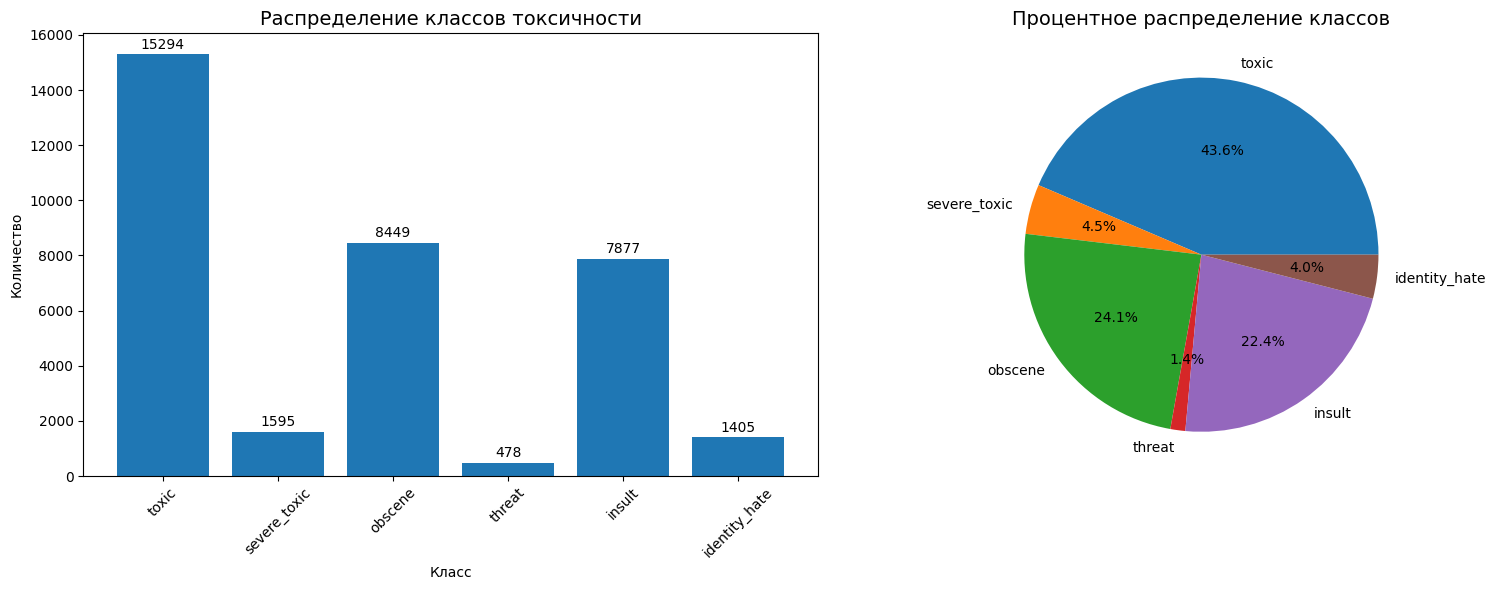

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bars = axes[0].bar(class_stats_df['Класс'], class_stats_df['Количество'])
axes[0].set_title('Распределение классов токсичности', fontsize=14)
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Количество')
axes[0].tick_params(axis='x', rotation=45)
for bar, value in zip(bars, class_stats_df['Количество']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                str(value), ha='center', va='bottom')

axes[1].pie(class_stats_df['Количество'], labels=class_stats_df['Класс'], autopct='%1.1f%%')
axes[1].set_title('Процентное распределение классов', fontsize=14)
plt.tight_layout()
plt.show()

Количество меток в комментариях:
0 меток: 143346 комментариев (89.83%)
1 меток: 6360 комментариев (3.99%)
2 меток: 3480 комментариев (2.18%)
3 меток: 4209 комментариев (2.64%)
4 меток: 1760 комментариев (1.10%)
5 меток: 385 комментариев (0.24%)
6 меток: 31 комментариев (0.02%)


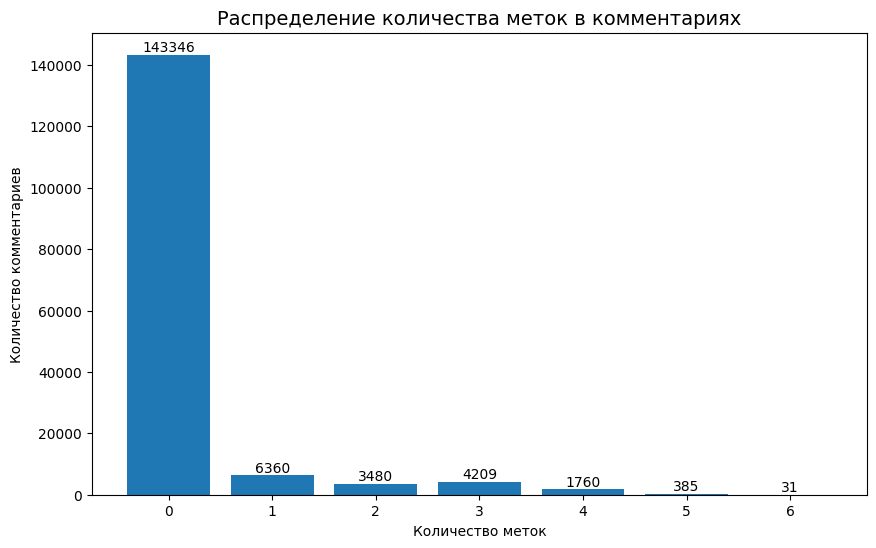

In [43]:
train_df['num_labels'] = train_df[target_cols].sum(axis=1)
label_counts = train_df['num_labels'].value_counts().sort_index()

print("Количество меток в комментариях:")
for num_labels, count in label_counts.items():
    percentage = 100 * count / len(train_df)
    print(f"{num_labels} меток: {count} комментариев ({percentage:.2f}%)")

plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index.astype(str), label_counts.values)
plt.title('Распределение количества меток в комментариях', fontsize=14)
plt.xlabel('Количество меток')
plt.ylabel('Количество комментариев')

for bar, value in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            str(value), ha='center', va='bottom')

plt.show()

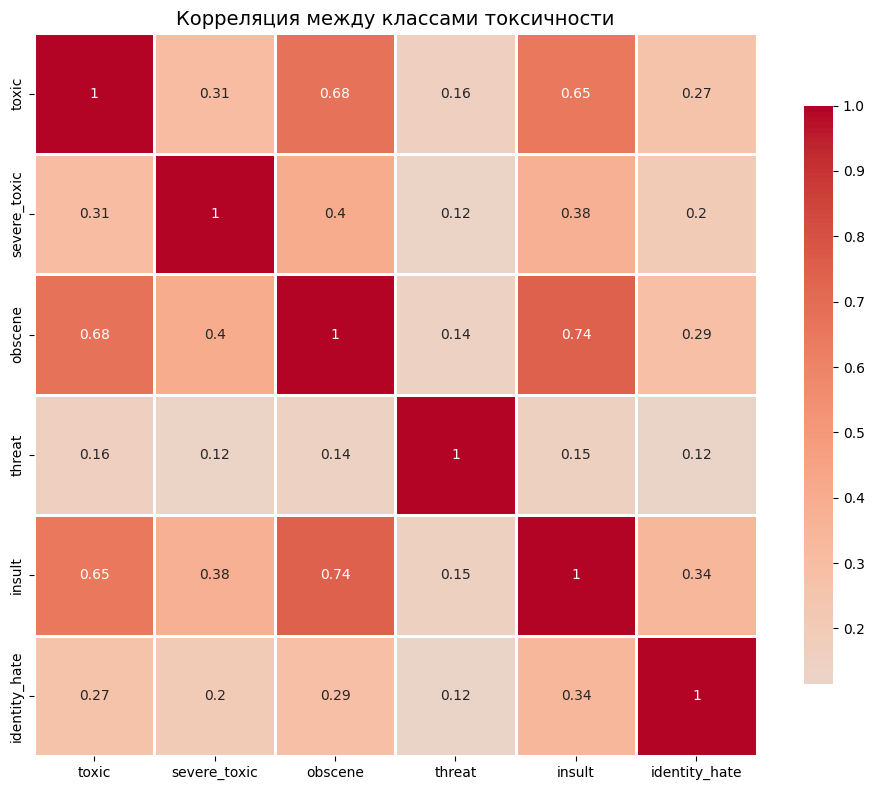

In [111]:
correlation_matrix = train_df[target_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляция между классами токсичности', fontsize=14)
plt.tight_layout()
plt.show()

## Анализ признаков

In [44]:
print("Пропущенные значения:")
missing_values = train_df.isnull().sum()
print(missing_values[missing_values > 0])

Пропущенные значения:
Series([], dtype: int64)


In [45]:
duplicates = train_df.duplicated(subset=['comment_text']).sum()
print(f"Количество дубликатов текста: {duplicates}")

Количество дубликатов текста: 0


Т.к. это задача классификации текста создадим дополнительные числовые признаки для анализа

In [46]:
train_df['text_length'] = train_df['comment_text'].apply(len)
train_df['word_count'] = train_df['comment_text'].apply(lambda x: len(str(x).split()))
train_df['char_count'] = train_df['comment_text'].apply(lambda x: len(str(x).replace(" ", "")))
train_df['avg_word_length'] = train_df['char_count'] / train_df['word_count'].replace(0, np.nan)


In [47]:
print("Статистика по длине текста (символы):")
print(train_df['text_length'].describe())

print("\n")

print("Статистика по количеству слов:")
print(train_df['word_count'].describe())

Статистика по длине текста (символы):
count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64


Статистика по количеству слов:
count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: word_count, dtype: float64


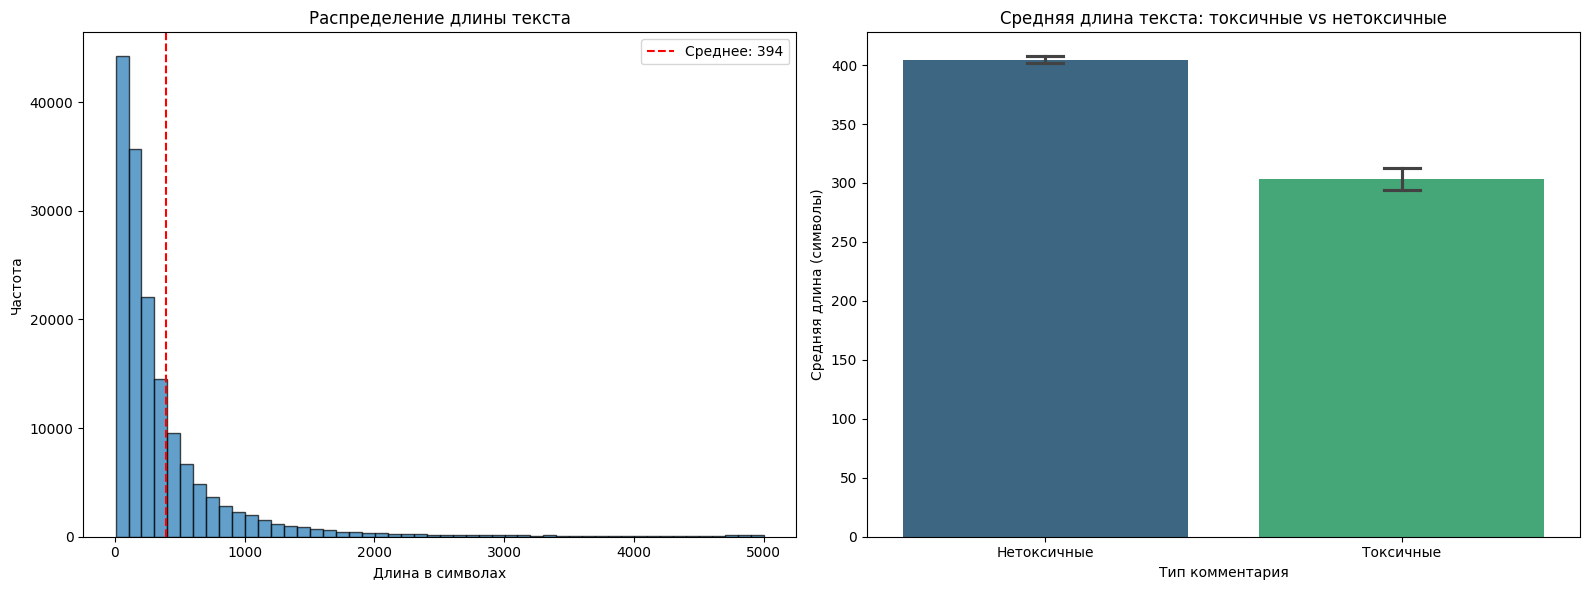

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 

axes[0].hist(train_df['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Распределение длины текста', fontsize=12)
axes[0].set_xlabel('Длина в символах')
axes[0].set_ylabel('Частота')
axes[0].axvline(train_df['text_length'].mean(), color='red', linestyle='--',
                  label=f'Среднее: {train_df["text_length"].mean():.0f}')
axes[0].legend()


train_df['status'] = train_df['num_labels'].apply(lambda x: 'Токсичные' if x > 0 else 'Нетоксичные')
sns.barplot(data=train_df, x='status', y='text_length', ax=axes[1], palette='viridis', capsize=.1)

axes[1].set_title('Средняя длина текста: токсичные vs нетоксичные', fontsize=12)
axes[1].set_xlabel('Тип комментария')
axes[1].set_ylabel('Средняя длина (символы)')

train_df.drop(columns=['status'], inplace=True)

plt.tight_layout()
plt.show()


In [113]:
Q1 = train_df['text_length'].quantile(0.25)
Q3 = train_df['text_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_df[(train_df['text_length'] < lower_bound) | (train_df['text_length'] > upper_bound)]
print(f"Выбросы по длине текста: {len(outliers)} комментариев ({100*len(outliers)/len(train_df):.2f}%)")

Выбросы по длине текста: 14658 комментариев (9.19%)


Анализ самых частых слов

20 самых частых слов во всех комментариях:
the: 490031
to: 294069
of: 222834
and: 218120
a: 211778
i: 196695
you: 187782
is: 170753
that: 146478
in: 140540
it: 109868
for: 100838
not: 88645
this: 88288
on: 87129
be: 81887
": 81755
as: 75524
have: 71273
are: 70102


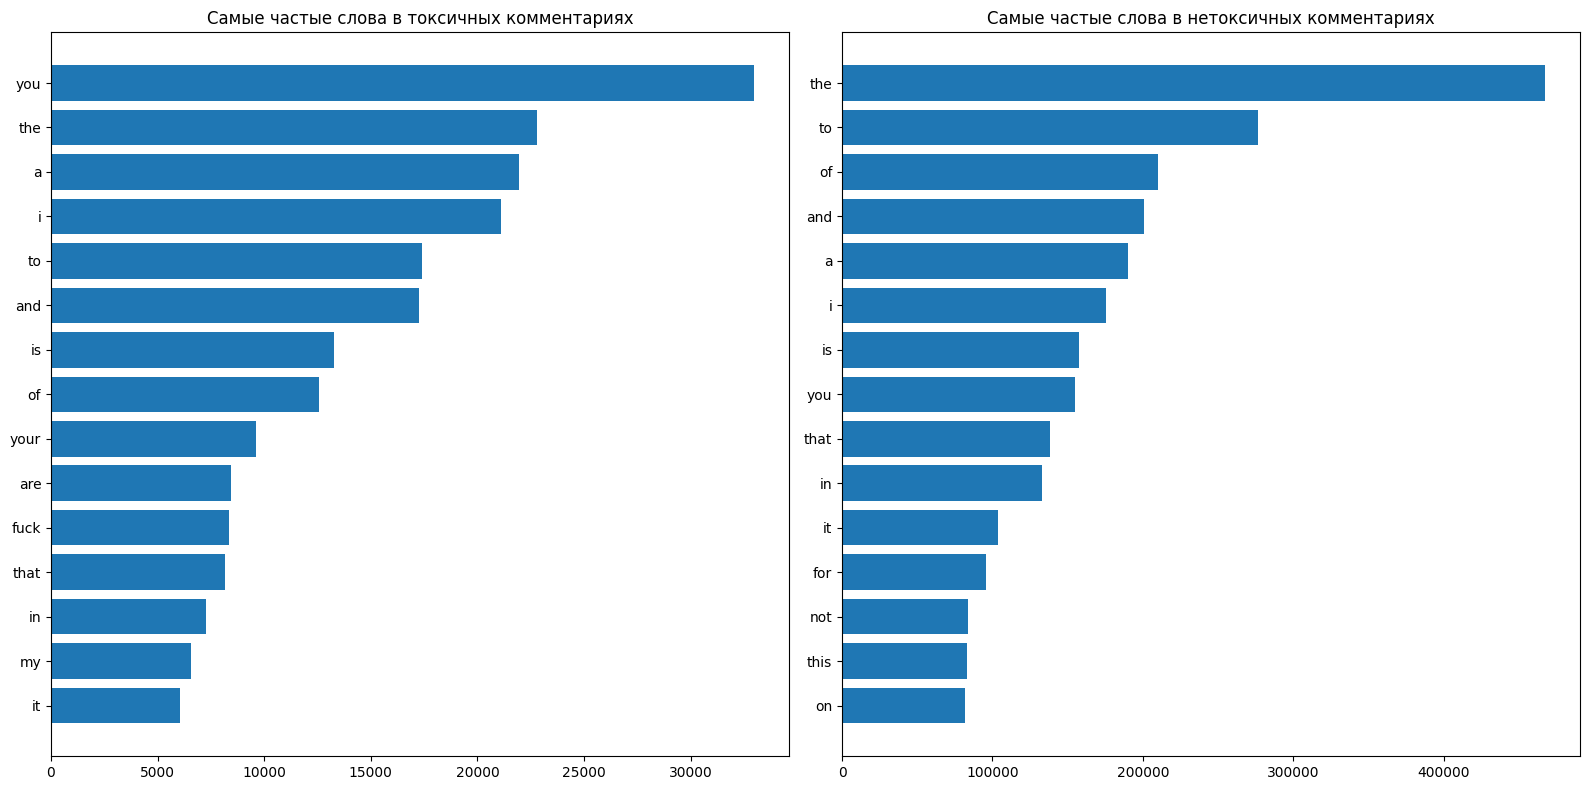

In [50]:
print("Анализ самых частых слов")

def get_top_words(text_series, n=20):
    all_words = []
    for text in text_series:
        words = str(text).lower().split()
        all_words.extend(words)

    word_counts = Counter(all_words)
    return word_counts.most_common(n)

all_top_words = get_top_words(train_df['comment_text'], 20)
print("\n20 самых частых слов во всех комментариях:")
for word, count in all_top_words:
    print(f"{word}: {count}")

toxic_comments = train_df[train_df['num_labels'] > 0]['comment_text']
non_toxic_comments = train_df[train_df['num_labels'] == 0]['comment_text']

toxic_top_words = get_top_words(toxic_comments, 15)
non_toxic_top_words = get_top_words(non_toxic_comments, 15)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

toxic_words, toxic_counts = zip(*toxic_top_words)
axes[0].barh(range(len(toxic_words)), toxic_counts)
axes[0].set_yticks(range(len(toxic_words)))
axes[0].set_yticklabels(toxic_words)
axes[0].set_title('Самые частые слова в токсичных комментариях', fontsize=12)
axes[0].invert_yaxis()

non_toxic_words, non_toxic_counts = zip(*non_toxic_top_words)
axes[1].barh(range(len(non_toxic_words)), non_toxic_counts)
axes[1].set_yticks(range(len(non_toxic_words)))
axes[1].set_yticklabels(non_toxic_words)
axes[1].set_title('Самые частые слова в нетоксичных комментариях', fontsize=12)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


Анализ длины текста по классам токсичности


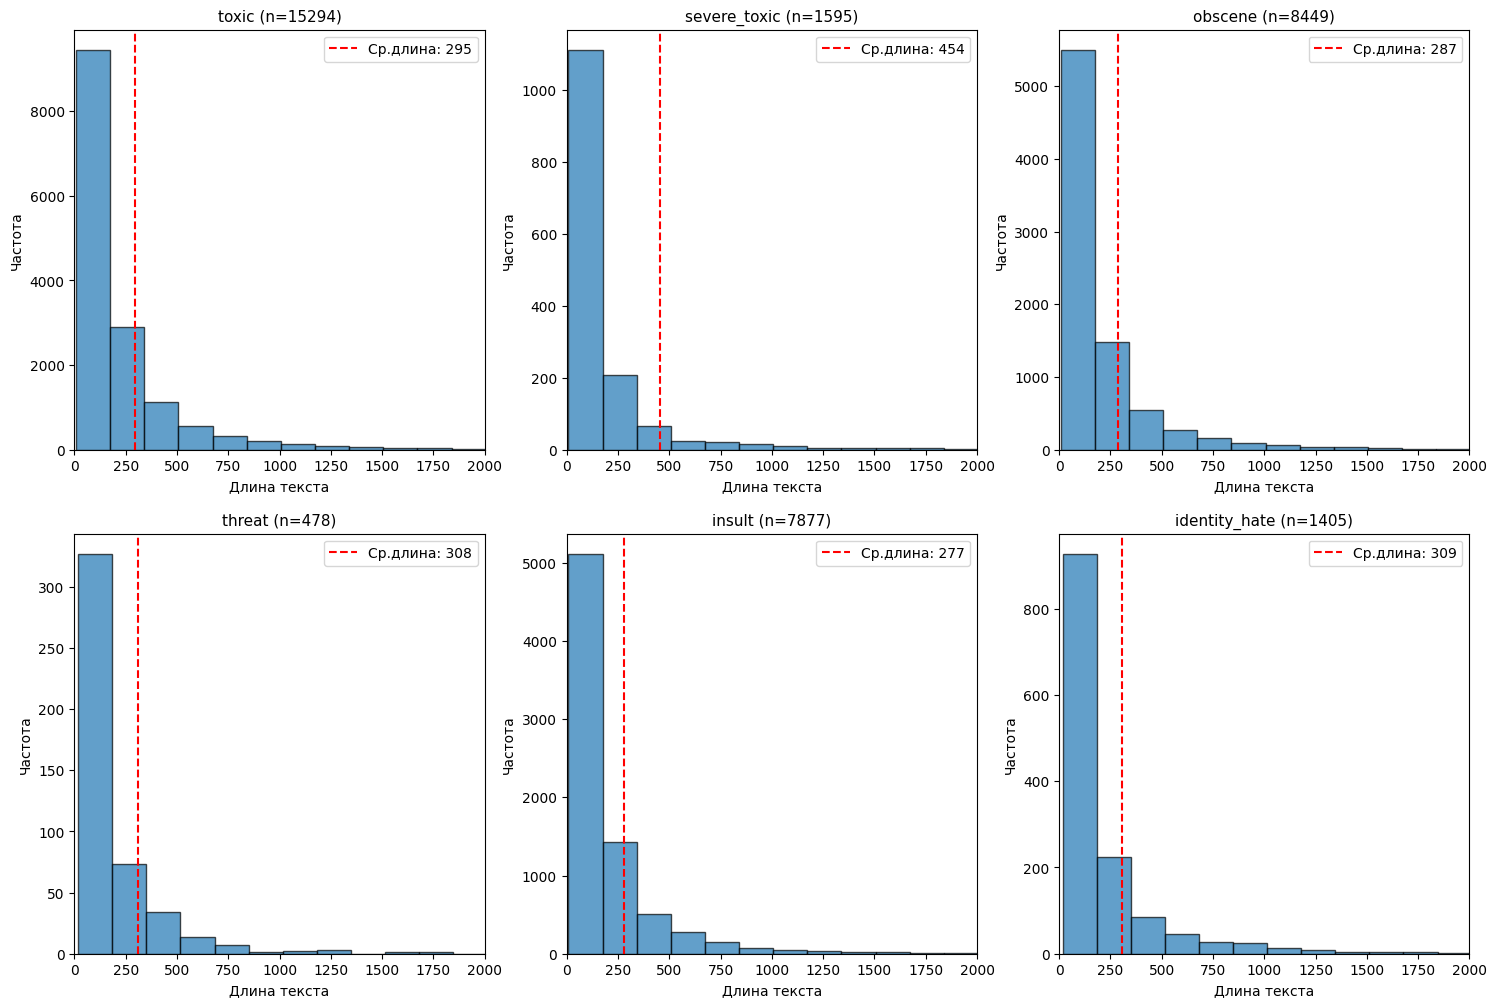

In [115]:
print("Анализ длины текста по классам токсичности")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target_col in enumerate(target_cols):
    target_texts = train_df[train_df[target_col] == 1]['comment_text']

    if len(target_texts) > 0:
        axes[idx].hist(target_texts.apply(len), bins=30, alpha=0.7, edgecolor='black')
        
        axes[idx].set_xlim(0, 2000) 
        
        axes[idx].set_title(f'{target_col} (n={len(target_texts)})', fontsize=11)
        axes[idx].set_xlabel('Длина текста')
        axes[idx].set_ylabel('Частота')

        mean_len = target_texts.apply(len).mean()
        axes[idx].axvline(mean_len, color='red', linestyle='--',
                         label=f'Ср.длина: {mean_len:.0f}')
        axes[idx].legend()

Выводы по анализу признаков:

Большинство комментариев нетоксичные, некоторые комментарии имеют несколько меток т.е. метки не взаимоисключающие, классы 'toxic', 'obscene' и 'insult' сильно коррелируют. 

# Feature engineering

Добваим несколько числовых признаков, которые могут помочь в определении того, насколько текст токсичный. Процент капса, кол-во восклицательных знаков, кол-во уникальных слов и прочие. TF-IDF фичи создаем тут, хоть они и могут автоматически создаваться в LAMA, при автоматическом создании есть ошибка которую я не победила

In [92]:
class TextStatsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, text_col='comment_text'):
        self.text_col = text_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        texts = df[self.text_col].astype(str)

        df['text_length'] = texts.apply(len)
        df['word_count'] = texts.apply(lambda x: len(x.split()))
        df['char_count'] = texts.apply(lambda x: len(x.replace(" ", "")))
        df['avg_word_length'] = df['char_count'] / df['word_count'].replace(0, np.nan)

        df['num_exclamation_marks'] = texts.str.count('!')
        df['num_question_marks'] = texts.str.count(r'\?')
        df['num_uppercase_chars'] = texts.apply(lambda x: sum(1 for c in x if c.isupper()))
        df['uppercase_ratio'] = df['num_uppercase_chars'] / df['char_count'].replace(0, np.nan)
        df['num_punctuations'] = texts.str.count(r'[^\w\s]')
        df['num_unique_words'] = texts.apply(lambda x: len(set(x.split())))
        df['unique_word_ratio'] = df['num_unique_words'] / df['word_count'].replace(0, np.nan)

        return df


Для корректной оценки модели используем разбиение train_test_split со stratify по признаку токсичности (наличие хотя бы одной метки токсичности в целевых переменных).
Так доля токсичных комментариев одинакова в train и val выборках

Также тестовый датафрейм из соревнования (test_df) не используется на этапе подбора признаков или настройки гиперпараметров - он будет использоваться только для финальной оценки

In [93]:
n_samples = 10000 
train_sample = train_df.sample(n=n_samples, random_state=42).reset_index(drop=True)

In [94]:
X = train_sample[['id', 'comment_text']]
y = train_sample[target_cols]

y_strat = y.sum(axis=1) > 0  #токсичный / не токсичный
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_strat
)

print(f"Train shape: {X_train.shape}, Val shape: {X_valid.shape}")

Train shape: (8000, 2), Val shape: (2000, 2)


In [97]:
text_stats = TextStatsExtractor()

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), stop_words='english')

tfidf_matrix = tfidf.fit_transform(X_train['comment_text'])
tfidf_valid = tfidf.transform(X_valid['comment_text'])

X_train_stats = text_stats.fit_transform(X_train)
X_valid_stats = text_stats.transform(X_valid)

X_train_final = np.hstack([X_train_stats.drop(columns=['comment_text']).values, tfidf_matrix.toarray()])
X_valid_final = np.hstack([X_valid_stats.drop(columns=['comment_text']).values, tfidf_valid.toarray()])

train_lama = pd.DataFrame(X_train_final)
train_lama[target_cols] = y_train.reset_index(drop=True)
valid_lama = pd.DataFrame(X_valid_final)

In [98]:
train_lama.columns = train_lama.columns.astype(str)
valid_lama.columns = valid_lama.columns.astype(str)


# Light AutoML baseline

Сделаем два варианта LAMA бейслайна - один базовый, с ограничениями на время поиска параметров 5 минут, двумя моделями

In [70]:
task = Task('multilabel', metric='logloss')

automl_basic = TabularAutoML(
    task=task,
    timeout=600,
    cpu_limit=4,
    reader_params={'n_jobs': 4, 'cv': 3, 'random_state': 42},
    tuning_params={'max_tuning_time': 300},
    general_params={'use_algos': [['linear_l2', 'rf']]}
)

roles = {'target': target_cols, 'category': ['0']}
oof_pred = automl_basic.fit_predict(train_lama, roles=roles)
valid_pred = automl_basic.predict(valid_lama)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    8.3s finished
[

Второй продвинутый - больше времени на вычисление и подбор параметров, ансамбль с моделью для сглаживания ошибок

In [71]:
automl_adv = TabularAutoML(
    task=task,
    timeout=900,
    cpu_limit=4,
    reader_params={'n_jobs': 4, 'cv': 3, 'random_state': 42},
    tuning_params={'max_tuning_time': 400},
        general_params={'use_algos': [
        ['linear_l2', 'catboost_tuned', 'rf'],  
        ['linear_l2']  
    ]}
)

oof_pred_adv = automl_adv.fit_predict(train_lama, roles=roles)
valid_pred_adv = automl_adv.predict(valid_lama)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   10.0s finished
[

In [72]:
def evaluate_lama(pred_dataset, y_true_df, model_name="LAMA baseline"):
    preds = pred_dataset.data
    y_true = y_true_df.values

    aucs, losses = {}, {}

    for i, col in enumerate(y_true_df.columns):
        try:
            auc = roc_auc_score(y_true[:, i], preds[:, i])
            loss = log_loss(y_true[:, i], preds[:, i])
        except ValueError:
            auc, loss = np.nan, np.nan
        aucs[col] = auc
        losses[col] = loss
        print(f"{col:15s} | ROC-AUC: {auc:.4f} | LogLoss: {loss:.4f}")

    print(f"Mean ROC-AUC: {np.nanmean(list(aucs.values())):.4f}")
    print(f"Mean LogLoss: {np.nanmean(list(losses.values())):.4f}")

    return pd.DataFrame({
        'target': y_true_df.columns,
        'roc_auc': [aucs[c] for c in y_true_df.columns],
        'logloss': [losses[c] for c in y_true_df.columns]
    })


toxic           | ROC-AUC: 0.9209 | LogLoss: 0.1807
severe_toxic    | ROC-AUC: 0.9582 | LogLoss: 0.0475
obscene         | ROC-AUC: 0.9499 | LogLoss: 0.1164
threat          | ROC-AUC: 0.8929 | LogLoss: 0.0214
insult          | ROC-AUC: 0.9412 | LogLoss: 0.1146
identity_hate   | ROC-AUC: 0.8167 | LogLoss: 0.0382
Mean ROC-AUC: 0.9133
Mean LogLoss: 0.0865
toxic           | ROC-AUC: 0.9158 | LogLoss: 0.1776
severe_toxic    | ROC-AUC: 0.9664 | LogLoss: 0.0443
obscene         | ROC-AUC: 0.9435 | LogLoss: 0.1133
threat          | ROC-AUC: 0.9024 | LogLoss: 0.0200
insult          | ROC-AUC: 0.9397 | LogLoss: 0.1141
identity_hate   | ROC-AUC: 0.8446 | LogLoss: 0.0370
Mean ROC-AUC: 0.9187
Mean LogLoss: 0.0844


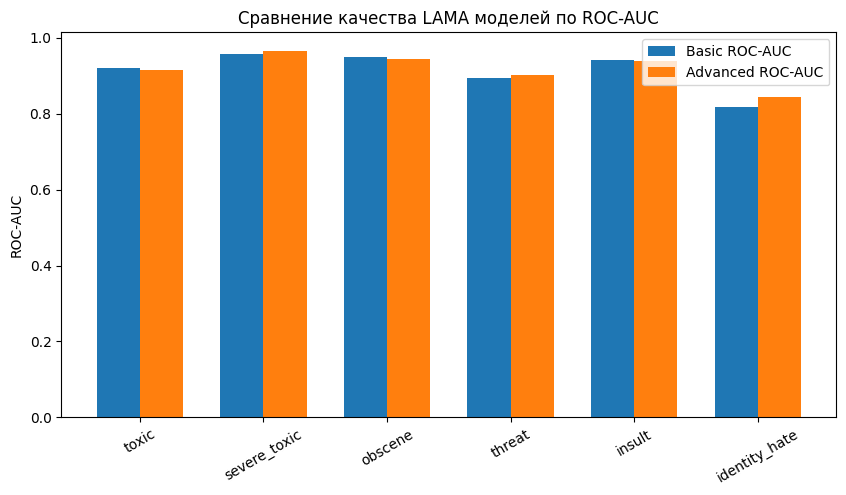

In [78]:
results_basic = evaluate_lama(valid_pred, y_valid, model_name="LAMA Basic")
results_adv = evaluate_lama(valid_pred_adv, y_valid, model_name="LAMA Advanced")

plt.figure(figsize=(10, 5))
x = np.arange(len(target_cols))
width = 0.35

plt.bar(x - width/2, results_basic['roc_auc'], width, label='Basic ROC-AUC')
plt.bar(x + width/2, results_adv['roc_auc'], width, label='Advanced ROC-AUC')
plt.xticks(x, target_cols, rotation=30)
plt.ylabel("ROC-AUC")
plt.title("Сравнение качества LAMA моделей по ROC-AUC")
plt.legend()
plt.show()

Варианты не особо сильно отличаются, но по roc-auc у advanced пайплайна чуть лучше

In [117]:
def lama_preds_to_df(val_pred, df_ids):
    preds = val_pred.data
    df = df_ids.copy().reset_index(drop=True)
    df[target_cols] = preds
    return df

results_basic_df = lama_preds_to_df(valid_pred, X_valid[['id']])
results_adv_df = lama_preds_to_df(valid_pred_adv, X_valid[['id']])


# Alternative solutions

In [126]:
num_features = ['text_length', 'word_count', 'char_count', 'avg_word_length',
                'num_exclamation_marks','num_question_marks','num_uppercase_chars',
                'uppercase_ratio','num_punctuations','num_unique_words','unique_word_ratio']
cat_features = ['id']

Решение 1 - логистическая регрессия и tf-idf с optuna

In [119]:
def objective_lr(trial):
    C = trial.suggest_float("C", 1e-3, 10.0, log=True)
    max_features = trial.suggest_int("max_features", 3000, 5000, step=1000)
    ngram = trial.suggest_int("ngram", 1, 2)
    
    preproc = ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('text', TfidfVectorizer(max_features=max_features, ngram_range=(1,ngram)), 'comment_text')
    ])
    
    pipe = Pipeline([
        ('preproc', preproc),
        ('clf', MultiOutputClassifier(LogisticRegression(C=C,max_iter=200)))
    ])
    
    score = cross_val_score(pipe, X_train_stats, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return score

In [105]:
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=15)
best_params = study_lr.best_params

pipe_lr_optuna = Pipeline([
    ('preproc', ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('text', TfidfVectorizer(max_features=best_params['max_features'], ngram_range=(1,best_params['ngram'])), 'comment_text')
    ])),
    ('clf', MultiOutputClassifier(LogisticRegression(C=best_params['C'], max_iter=200)))
])
pipe_lr_optuna.fit(X_train_stats, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preproc', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [120]:
preds_lr_proba = pipe_lr_optuna.predict_proba(X_valid_stats)
preds_lr_array = np.stack([p[:,1] for p in preds_lr_proba], axis=1)
results_lr_df = X_valid_stats[['id']].copy().reset_index(drop=True)
results_lr_df[target_cols] = preds_lr_array

Решение 2 - random forest и tf-idf с optuna 

In [133]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators',100,500,step=100)
    max_depth = trial.suggest_int('max_depth',5,20)
    min_samples_split = trial.suggest_int('min_samples_split',2,8)
    max_features = trial.suggest_int("max_features", 3000, 4000, step=1000)

    preproc = ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('text', TfidfVectorizer(max_features=max_features, ngram_range=(1,2)), 'comment_text')
    ])

    pipe = Pipeline([
        ('preproc', preproc),
        ('clf', MultiOutputClassifier(RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )))
    ])
    
    score = cross_val_score(pipe, X_train_stats, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return score

In [134]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=15)
best_rf_params = study_rf.best_params

pipe_rf_optuna = Pipeline([
    ('preproc', ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('text', TfidfVectorizer(max_features=best_params['max_features'], ngram_range=(1,2)), 'comment_text')
    ])),
    ('clf', MultiOutputClassifier(RandomForestClassifier(
        n_estimators=best_rf_params['n_estimators'],
        max_depth=best_rf_params['max_depth'],
        min_samples_split=best_rf_params['min_samples_split'],
        random_state=42,
        n_jobs=-1
    )))
])
pipe_rf_optuna.fit(X_train_stats, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preproc', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [135]:
preds_rf_proba = pipe_rf_optuna.predict_proba(X_valid_stats)
preds_rf_array = np.stack([p[:,1] for p in preds_rf_proba], axis=1)
results_rf_df = X_valid_stats[['id']].copy().reset_index(drop=True)
results_rf_df[target_cols] = preds_rf_array

Решение 3 - lgbm и tf-idf с optuna 

In [162]:
def objective_lgb(trial):
    n_estimators = trial.suggest_int('n_estimators',100,300,step=100)
    max_depth = trial.suggest_int('max_depth',4,6)
    learning_rate = trial.suggest_float('learning_rate',0.05,0.1,log=True)
    max_features = trial.suggest_int("max_features", 3000, 4000, step=1000)

    preproc = ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('text', TfidfVectorizer(max_features=max_features, ngram_range=(1,2)), 'comment_text')
    ])
    
    pipe = Pipeline([
        ('preproc', preproc),
        ('clf', MultiOutputClassifier(LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=0.8,
            n_jobs=-1,
            random_state=42
        )))
    ])
    
    score = cross_val_score(pipe, X_train_stats, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return score

In [153]:
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=5)
best_lgb_params = study_lgb.best_params

pipe_lgb_optuna = Pipeline([
    ('preproc', ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('text', TfidfVectorizer(max_features=best_lgb_params['max_features'], ngram_range=(1,2)), 'comment_text')
    ])),
    ('clf', MultiOutputClassifier(LGBMClassifier(
        n_estimators=best_lgb_params['n_estimators'],
        max_depth=best_lgb_params['max_depth'],
        learning_rate=best_lgb_params['learning_rate'],
        subsample=0.8,
        n_jobs=-1,
        random_state=42
    )))
])

pipe_lgb_optuna.fit(X_train_stats, y_train)

[LightGBM] [Info] Number of positive: 749, number of negative: 7251
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113886
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3792
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093625 -> initscore=-2.270156
[LightGBM] [Info] Start training from score -2.270156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preproc', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [154]:
preds_lgb_proba = pipe_lgb_optuna.predict_proba(X_valid_stats)
preds_lgb_array = np.stack([p[:,1] for p in preds_lgb_proba], axis=1)
results_lgb_df = X_valid_stats[['id']].copy().reset_index(drop=True)
results_lgb_df[target_cols] = preds_lgb_array

# Сравнение моделей

In [155]:
all_results = {
    'LAMA Basic': results_basic_df,
    'LAMA Advanced': results_adv_df,
    'Pipeline LR': results_lr_df,
    'Pipeline RF': results_rf_df,
    'Pipeline LGBM': results_lgb_df
}

In [156]:
mean_auc_scores = {}
for name, df in all_results.items():
    aucs = [roc_auc_score(y_valid[col], df[col]) for col in target_cols]
    mean_auc_scores[name] = np.mean(aucs)
    print(f"{name}: mean ROC-AUC = {mean_auc_scores[name]:.4f}")

LAMA Basic: mean ROC-AUC = 0.9133
LAMA Advanced: mean ROC-AUC = 0.9187
Pipeline LR: mean ROC-AUC = 0.9366
Pipeline RF: mean ROC-AUC = 0.9182
Pipeline LGBM: mean ROC-AUC = 0.8943


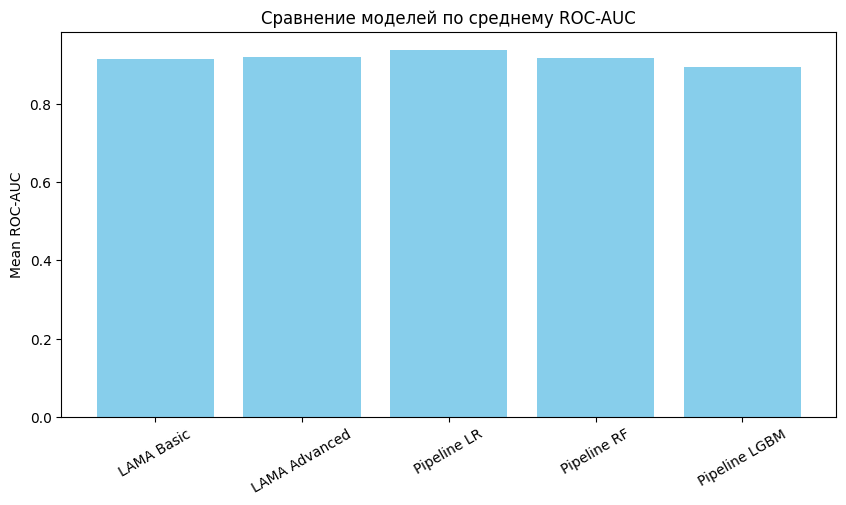

In [157]:
plt.figure(figsize=(10,5))
plt.bar(mean_auc_scores.keys(), mean_auc_scores.values(), color='skyblue')
plt.ylabel("Mean ROC-AUC")
plt.xticks(rotation=30)
plt.title("Сравнение моделей по среднему ROC-AUC")
plt.show()

In [158]:
best_model_name = max(mean_auc_scores, key=mean_auc_scores.get)
print(f"Лучшая модель: {best_model_name} с mean ROC-AUC = {mean_auc_scores[best_model_name]:.4f}")

Лучшая модель: Pipeline LR с mean ROC-AUC = 0.9366


# Итоги

В рамках проводимых экспериментов победить LAMA (с установленными на нее c ограничениями по времени) удалось. Лучший результат у пайплайна tf-idf + logistic regression - ROC-AUC 0.9366 на валидационной выборке